In [1]:
import acquire as a
import prepare as p
import wrangle as w
import explore as e
import model as m
import evaluate as eval

import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


from sklearn.preprocessing import MinMaxScaler, RobustScaler

https://pen.do/support/difference-between-property-and-unit/

# Acquire

In [2]:
#Acquire data from SQL using my function

In [3]:
sql_query = '''
SELECT  parcelid, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
taxvaluedollarcnt 
FROM properties_2017
JOIN predictions_2017 as pred USING (parcelid)
WHERE pred.transactiondate >= '2017-05-01' AND pred.transactiondate <= '2017-08-31'
AND (propertylandusetypeid > 259 AND propertylandusetypeid  < 265);
'''

In [4]:
df= a.get_data_from_sql('zillow',sql_query)

In [5]:
#check my df
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
0,11721753,3.0,2.0,1316.0,205123.0
1,11289917,3.0,2.0,1458.0,136104.0
2,11705026,2.0,1.0,1421.0,35606.0
3,14269464,4.0,3.0,2541.0,880456.0
4,11446756,3.0,2.0,1491.0,107110.0


In [6]:
df.shape

(28185, 5)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,28185.0,1.304103e+07,3.744921e+06,10711855.0,11510818.00,12593855.0,14148993.0,167687839.0
bedroomcnt,28185.0,3.307007e+00,9.500449e-01,0.0,3.00,3.0,4.0,12.0
bathroomcnt,28185.0,2.314866e+00,1.019092e+00,0.0,2.00,2.0,3.0,11.0
calculatedfinishedsquarefeet,28117.0,1.935100e+03,9.959107e+02,240.0,1278.00,1675.0,2326.0,17245.0
taxvaluedollarcnt,28184.0,5.353762e+05,7.086644e+05,1000.0,198610.75,382446.0,632716.5,23858374.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28185 entries, 0 to 28184
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28185 non-null  int64  
 1   bedroomcnt                    28185 non-null  float64
 2   bathroomcnt                   28185 non-null  float64
 3   calculatedfinishedsquarefeet  28117 non-null  float64
 4   taxvaluedollarcnt             28184 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.1 MB


**takeaways**
- My sql query filter:
   - single unit property .
   - transaction during  May-August, 2017
- calculatedfinishedsquarefee and taxvaluedollarcnt have missing values

# Prepare

In [9]:
#use a function that gives us a quick report
w.miss_dup_values(df)

Your selected dataframe has 5 columns.
There are 2 columns that have missing values.
  
** There are 25 duplicate rows that represents 0.09% of total Values**


,Missing Values,% of Total Values
calculatedfinishedsquarefeet,68,0.2
taxvaluedollarcnt,1,0.0


In [10]:
# I'm going to drop duplicates

In [11]:
df = df.drop_duplicates()

In [12]:
#I'm going to drop the rows with missing values

In [13]:
df = df.dropna(how='any',axis=0)

In [14]:
w.miss_dup_values(df)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28093 entries, 0 to 28184
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28093 non-null  int64  
 1   bedroomcnt                    28093 non-null  float64
 2   bathroomcnt                   28093 non-null  float64
 3   calculatedfinishedsquarefeet  28093 non-null  float64
 4   taxvaluedollarcnt             28093 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.3 MB


In [16]:
# I'm going to change parcelid to string, it is a uniqure identifier for parcels lots
df['parcelid'] = df['parcelid'].astype('str')

In [17]:
df.dtypes

parcelid                         object
bedroomcnt                      float64
bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
taxvaluedollarcnt               float64
dtype: object

In [18]:
df.rename(columns={'bedroomcnt': 'n_bedrooms', 
                    'bathroomcnt': 'n_bathrooms',
                    'calculatedfinishedsquarefeet':'sq_ft',
                     'taxvaluedollarcnt': 'assessed_value_usd'}, inplace=True)

In [19]:
#checking the uniques values for each column
columns = df.columns.tolist()
print( 'Columns')
print(" ")
cat_list = []
for col in columns:
    print(f'{col} --> {df[col].nunique()} unique values')
    if df[col].nunique() < 26:
        cat_list.append(col)
    print(" ")


Columns
 
parcelid --> 28093 unique values
 
n_bedrooms --> 13 unique values
 
n_bathrooms --> 20 unique values
 
sq_ft --> 4056 unique values
 
assessed_value_usd --> 22733 unique values
 


In [20]:
#checking  the variables that have few values
for l in cat_list:
    print(l)
    print(df[l].value_counts().sort_index())
    print("--------------------------- ")
    print(" ")

n_bedrooms
0.0        33
1.0       312
2.0      4347
3.0     12566
4.0      8286
5.0      2142
6.0       340
7.0        50
8.0         8
9.0         4
10.0        2
11.0        2
12.0        1
Name: n_bedrooms, dtype: int64
--------------------------- 
 
n_bathrooms
0.0        25
1.0      4903
1.5       451
2.0     11728
2.5      2208
3.0      5796
3.5       544
4.0      1198
4.5       384
5.0       443
5.5       111
6.0       176
6.5        27
7.0        52
7.5         9
8.0        29
8.5         1
9.0         5
10.0        1
11.0        2
Name: n_bathrooms, dtype: int64
--------------------------- 
 


** Takeaways**
- change parcelid to object type
- there are property whith 0 bedrooms and bathtooms. I will check this more

In [21]:
#explore n_bedrooms == 0 & n_bathroos == 0

In [22]:
df[(df.n_bedrooms == 0) & (df.n_bathrooms == 0)].count()

parcelid              19
n_bedrooms            19
n_bathrooms           19
sq_ft                 19
assessed_value_usd    19
dtype: int64

In [23]:
df[(df.n_bedrooms == 0) & (df.n_bathrooms == 0)]

,parcelid,n_bedrooms,n_bathrooms,sq_ft,assessed_value_usd
8,11696784,0.0,0.0,1378.0,168828.0
254,11392193,0.0,0.0,2276.0,101792.0
339,11266326,0.0,0.0,400.0,49627.0
795,11938527,0.0,0.0,389.0,319396.0
1795,14507431,0.0,0.0,4184.0,1145602.0
3714,12153898,0.0,0.0,682.0,29361.0
4940,12554886,0.0,0.0,1064.0,226328.0
6238,11676853,0.0,0.0,660.0,746757.0
6611,12444585,0.0,0.0,738.0,84701.0
9497,11679076,0.0,0.0,1820.0,1034512.0


In [24]:
df.shape

(28093, 5)

**I decided to keep the properties with 0 bathrooms and bedrooms it represents a small percentage**

In [25]:
#checking calculatedfinishedsquarefeet
df.sq_ft.sort_values().head(20)

18570    240.0
2389     300.0
8853     326.0
14594    360.0
1362     360.0
13627    366.0
25817    380.0
20469    384.0
795      389.0
339      400.0
9775     400.0
20088    400.0
27669    440.0
26082    440.0
22493    440.0
12738    442.0
12016    444.0
19968    444.0
3932     448.0
27329    448.0
Name: sq_ft, dtype: float64

In [26]:
df[(df.sq_ft <400)]

,parcelid,n_bedrooms,n_bathrooms,sq_ft,assessed_value_usd
795,11938527,0.0,0.0,389.0,319396.0
1362,11417048,1.0,1.0,360.0,206054.0
2389,17258105,1.0,1.0,300.0,165579.0
8853,11361390,2.0,1.0,326.0,16084.0
13627,11283520,0.0,0.0,366.0,62030.0
14594,12074776,0.0,0.0,360.0,11089.0
18570,11915330,0.0,1.0,240.0,380000.0
20469,14276688,1.0,1.0,384.0,1486936.0
25817,13910907,1.0,1.0,380.0,87906.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28093 entries, 0 to 28184
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   parcelid            28093 non-null  object 
 1   n_bedrooms          28093 non-null  float64
 2   n_bathrooms         28093 non-null  float64
 3   sq_ft               28093 non-null  float64
 4   assessed_value_usd  28093 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.3+ MB


**takeaway**
- I decided to keep bathrooms and bedrooms = 0


In [28]:
#pd.cut(df.n_bedrooms,  [0, 2, 4, 12])


In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
n_bedrooms,28093.0,3.314064,0.933615,0.0,3.0,3.0,4.0,12.0
n_bathrooms,28093.0,2.319920,1.013287,0.0,2.0,2.0,3.0,11.0
sq_ft,28093.0,1934.491475,994.195591,240.0,1279.0,1675.0,2326.0,17245.0
assessed_value_usd,28093.0,533148.215214,703712.863914,1000.0,198427.0,382000.0,631675.0,23858374.0


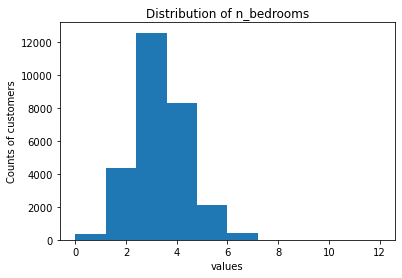

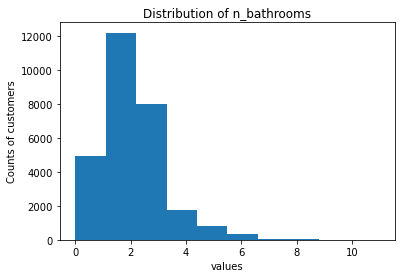

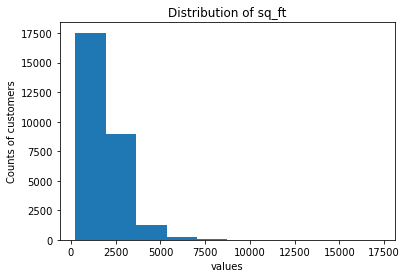

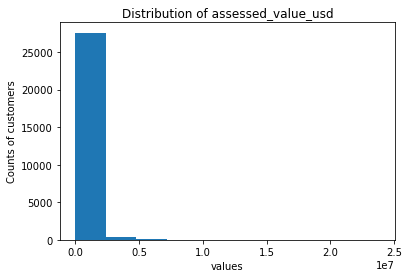

In [30]:
p.distribution(df)

because all my features are continous i decided to boxplot

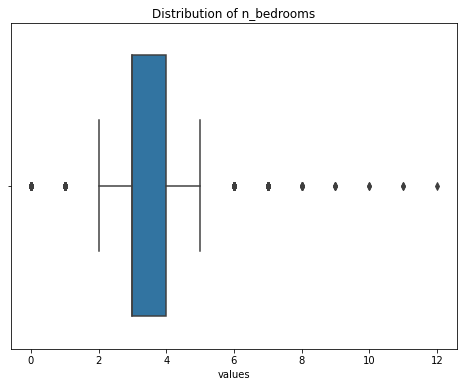

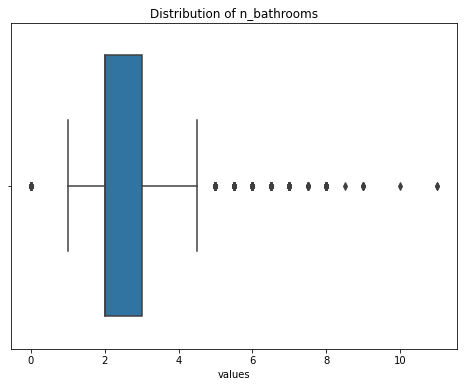

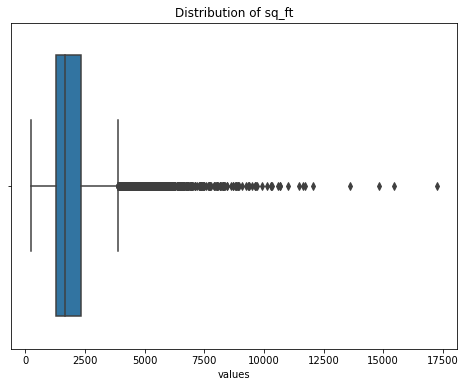

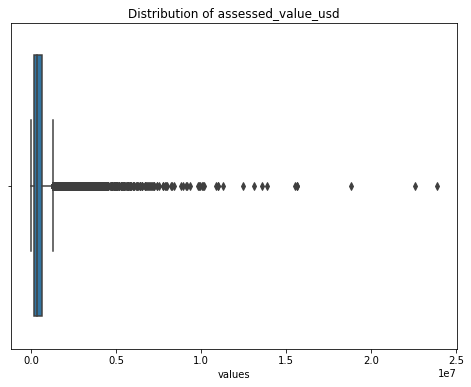

In [31]:
p.distribution_boxplot(df)

**Takeaways** 
-  bathrooms , bedrooms, sq_dt and usd_valure are continous.
- target is  usd_value


### split train, validate, test

In [32]:
train, validate, test = p.split_data(df)

train -> (15731, 5)
validate -> (6743, 5)
test -> (5619, 5)


In [33]:
X_train, y_train, X_validate, y_validate, X_test, y_test = p.split_Xy(train,validate,test, 'assessed_value_usd')

X_train -> (15731, 4)               y_train->(15731,)
X_validate -> (6743, 4)         y_validate->(6743,) 
X_test -> (5619, 4)                  y_test>(5619,)


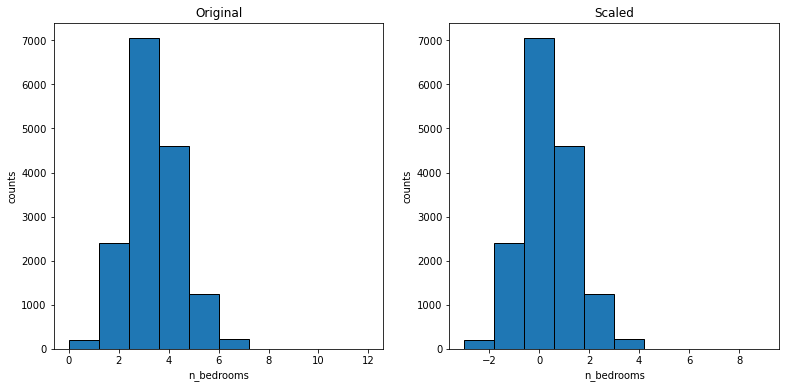

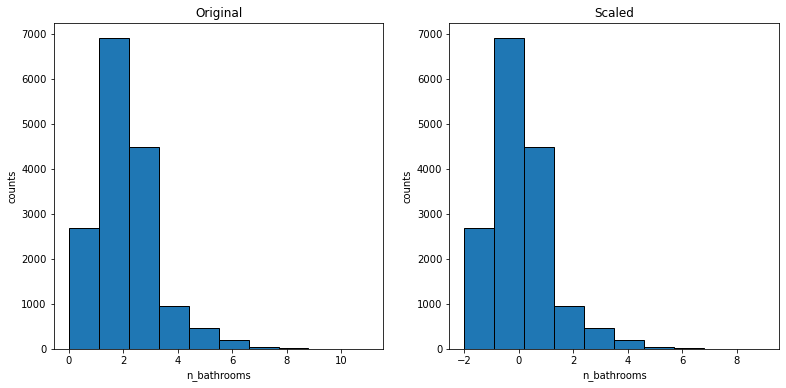

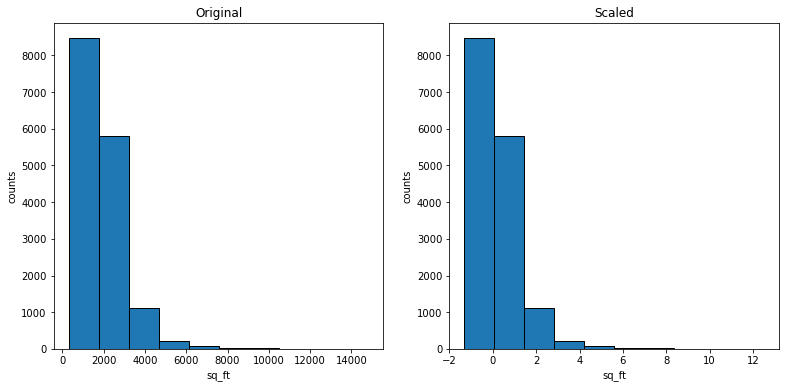

In [34]:
#Scale our data
X_train_scaled, X_validate_scaled, X_test_scaled = p.scaled_df(X_train, X_validate, X_test, RobustScaler())

**takeaways**
- I use Robust Scaler that uses parameters that are more robust to outliers,  because  bathrooms , bedrooms, and sq_dt have outliers.

# Expolore


before Exploration this is what I think:



- The variables that can influence the value of home are square feet, and number of bedrooms and at last number of bathrooms. 
- square feet, and number of bedrooms  can have an influence no matter where the property located.

-  other factors can influence the value of a home such as zip code, year built,  school district.

In [35]:
#  I want to explore with my target

<AxesSubplot:>

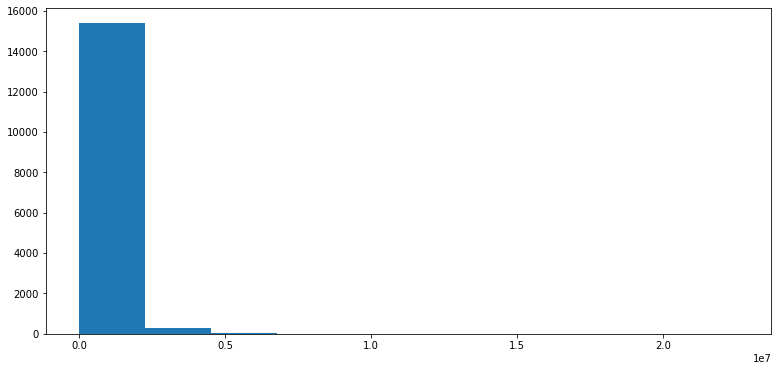

In [36]:
plt.figure(figsize=(13, 6))
train['assessed_value_usd'].hist(grid=False,)


<AxesSubplot:xlabel='assessed_value_usd'>

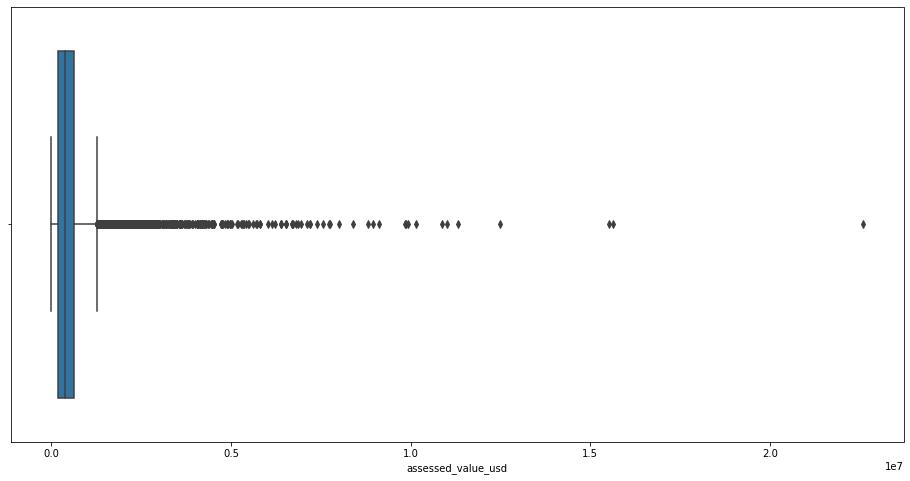

In [37]:
plt.figure(figsize=(16, 8))
sns.boxplot(train['assessed_value_usd'])

<Figure size 1152x576 with 0 Axes>

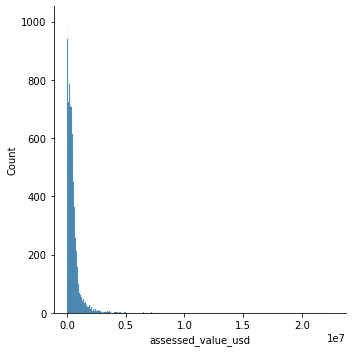

In [38]:
plt.figure(figsize=(16, 8))
sns.displot( train['assessed_value_usd'])


In [39]:
# I creating a new df 

In [40]:
train_scaled = pd.concat([X_train_scaled, pd.DataFrame( {'assessed_valure_usd': y_train}) ], axis= 1 )

In [41]:
train_scaled.head()

,n_bedrooms,n_bathrooms,sq_ft,assessed_valure_usd
20267,0.0,0.0,0.021884,232000.0
21840,1.0,1.0,0.512845,93881.0
10960,0.0,0.0,0.193149,143891.0
25650,0.0,1.0,0.469077,744630.0
11243,1.0,0.0,1.006660,496457.0


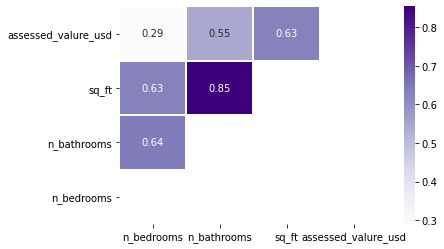

In [42]:
e.heatmap(train_scaled)

Features in order with more correlation with the target:

    - 1. sq_ft
    - 2. n_bathrooms
    - 3. n_bedrooms

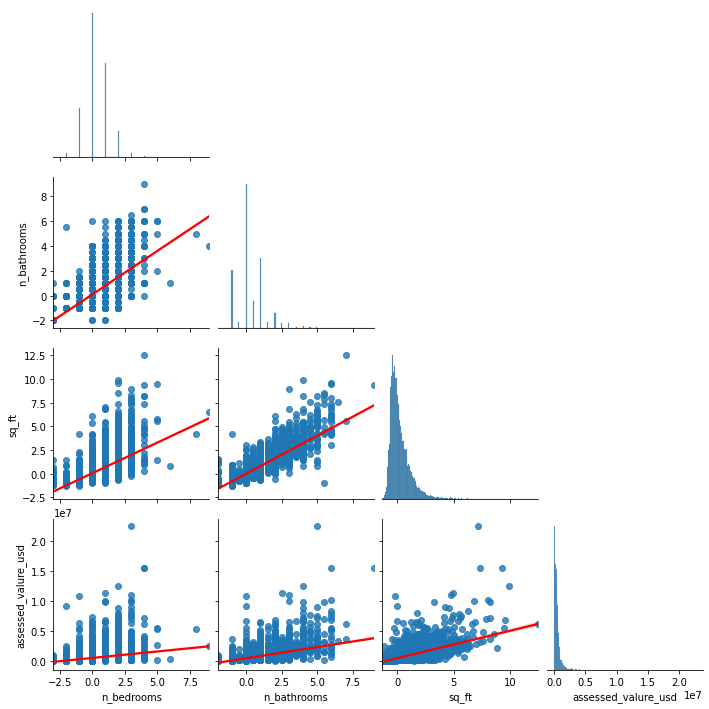

In [43]:
sns.pairplot(train_scaled, kind="reg", plot_kws={'line_kws':{'color':'red'}}, corner=True)

**Takeaways**
- sq_ft has more correlation with our target
- sq_ft has higher correlation n_bathrooms

## Statistical Tests

### - T-test

 **Is any diference in  the average of assessed_value_usd  for 2   bedrooms  vs 3 o bedrooms properties?**


 - 𝐻𝑜 : There is no difference in  the average of assessed_value_usd  for the properties with  3  bedrooms  vs 2 bedrooms
- 𝐻𝑎 : There is significant  difference in  the average of assessed_value_usd  for the properties with  3  bedrooms  vs 2 bedrooms



- **continous** = assessed_value_usd 
- **categorical** = 2 groups ( bedroom_2, bedroom_3)  
- **continous vs categorical** = 2-tailed (significantly different) , 2-sample (comparing 2 groups) t-test.

1. Set Significance Level: $\alpha = .05$ (in other words Confidence level is 0.95)

2. Verify Assumptions:

    - Normal Distribution, or at least 30 observations and "kinda" normal. The more observations you have, the less "normal" it needs to appear. (CLT)
    - Independent samples
    - Equal Variances (or set method argument to False when not)
3. Compute test statistic and probability (t-statistic & p-value) using stats.ttest_ind

In [44]:
# Set Significance Level
alpha = 0.05

In [45]:
train_scaled.head()

,n_bedrooms,n_bathrooms,sq_ft,assessed_valure_usd
20267,0.0,0.0,0.021884,232000.0
21840,1.0,1.0,0.512845,93881.0
10960,0.0,0.0,0.193149,143891.0
25650,0.0,1.0,0.469077,744630.0
11243,1.0,0.0,1.006660,496457.0


In [46]:
#create my groups
bedroom_2 = train_scaled[train_scaled.n_bedrooms == 2].assessed_valure_usd
bedroom_3 = train_scaled[train_scaled.n_bedrooms ==3 ].assessed_valure_usd

In [47]:
#Normal Distribution
bedroom_2.shape, bedroom_3.shape

((1252,), (192,))

In [48]:
# Equal Variances (or set method argument to False when not)
bedroom_2.var(), bedroom_3.var()

(1108840196072.28, 5940790657945.124)

In [49]:
#Compute Test Statistic
t, p = stats.ttest_ind(bedroom_2, bedroom_3, equal_var = False)
t,p

(-3.415146699023207, 0.0007704302459072129)

In [50]:
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


t is negative that means the average in assessed_value_usd is for 3 bedrooms is  greater  than 2 bedrooms

In [51]:
print('Average  assessed value  for 2 bedrooms is : $ ',round( bedroom_2.mean(), 2))
print('Average  assessed value  for 3 bedrooms is : $', round (bedroom_3.mean(), 2))

Average  assessed value  for 2 bedrooms is : $  994135.11
Average  assessed value  for 3 bedrooms is : $ 1603404.11


### - Correlation

Are bathrooms and bedrooms linearly correlated? 
- 𝐻𝑜 : There is not a linear correlation between number of bathrooms and number of bedrooms for a property.
- 𝐻𝑎 : There is a linear correlation between number of bathrooms and number of bedrooms for a property.


In [52]:
r, p = stats.pearsonr(train_scaled.n_bathrooms, train_scaled.n_bedrooms)
r, p

(0.6419012149429861, 0.0)

In [53]:
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


Text(-3, 8, 'Pearson r:0.6419\n p-stat: 0.00')

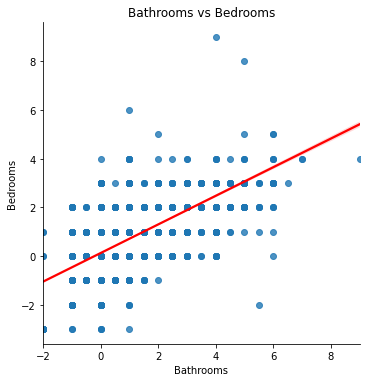

In [54]:

sns.lmplot(x = 'n_bathrooms', y= 'n_bedrooms', data = train_scaled, line_kws={'color': 'red'})
plt.xlabel('Bathrooms')
plt.ylabel('Bedrooms')
plt.title('Bathrooms vs Bedrooms')
plt.annotate(f'Pearson r:{r:.4f}\n p-stat: {p:.2f}', xy =(-3, 8))

**Takeaways**
- What independent variables are correlated with assessed_value_usd?
    - my surprise is bathrooms have higher correlation with our target than bedrooms
    - **sq_ft  looks to be the best predictor of our target variable**

- Which independent variables are correlated with other independent variables?
    - bathrooms and bedrooms are  correlated (if bedrooms increase  also bathrooms tend to increase)

# Modeling

### - Feature Engineering


    - SelectkBest

In [55]:
#using my function for SelectkBest
top_sb =m.select_kbest(X_train_scaled, y_train, 2)

The top 2 selected feautures based on the SelectKBest class are: ['n_bathrooms', 'sq_ft']


In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
#using my function for RFE
top_rfe = m.select_rfe(X_train_scaled, y_train, 2,LinearRegression() )

The top 2 selected feautures based on the the RFE class class are: ['n_bedrooms', 'sq_ft']
n_bedrooms     1
sq_ft          1
n_bathrooms    2
dtype: int64


### - Modeling

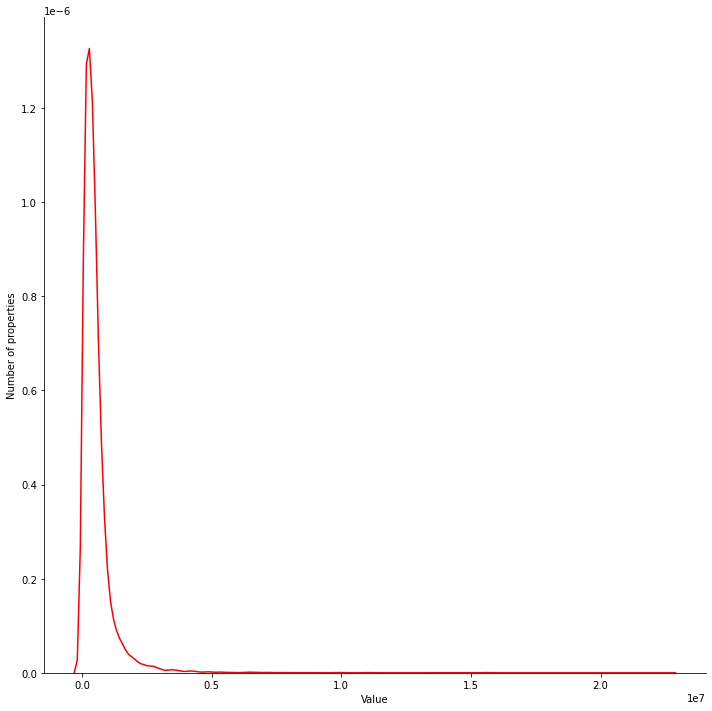

In [58]:
#plot our target
sns.displot(y_train,  kind="kde", height =10 ,aspect =1, color = 'red')
plt.xlabel("Value")
plt.ylabel("Number of properties")
plt.show()

In [59]:
y_train.describe()

count    1.573100e+04
mean     5.337625e+05
std      6.987870e+05
min      1.000000e+03
25%      1.962015e+05
50%      3.816400e+05
75%      6.289315e+05
max      2.258931e+07
Name: assessed_value_usd, dtype: float64

In [60]:
#conver y_train y _ validate to df
y_train = pd.DataFrame( {'actual': y_train})
y_validate = pd.DataFrame( {'actual': y_validate})

**Baseline**

I wil check mean and median for y_train. I will choose median, because as you can se in the plot of the target there are outliers

In [61]:
y_train.mean(), y_train.median()

(actual    533762.525014
 dtype: float64,
 actual    381640.0
 dtype: float64)

In [62]:
#create baseline using mean (I'm using my function to calculate rmse)
tra_m = eval.baseline_errors(y_train, 'actual', 'mean')
tra_m['rmse']

698764.7836050247

In [63]:
#let's calculate baseline in validate
val_m = eval.baseline_errors(y_validate, 'actual', 'mean')
val_m['rmse']

692399.5228061898

In [64]:
#create baseline using median
tra = eval.baseline_errors(y_train, 'actual', 'median')
tra['rmse']

715131.7958413708

In [65]:
#using median in validate
val = eval.baseline_errors(y_validate, 'actual', 'median')
val['rmse']

707034.128747132

**I will select mean for my baseline**

In [66]:
y_train.head()

,actual,yhat_baseline_mean,yhat_baseline_median
20267,232000.0,533762.525014,381640.0
21840,93881.0,533762.525014,381640.0
10960,143891.0,533762.525014,381640.0
25650,744630.0,533762.525014,381640.0
11243,496457.0,533762.525014,381640.0


In [67]:
metric_df = pd.DataFrame(data = [{
    'model': 'mean_baseline',
    'rmse_validate': val_m['rmse'],
    'r^2_validate' : val_m['r2']}])

In [68]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,692399.522806,0.0


#### Model1: LinearRegression (OLS)

In [69]:
def create_model (X_df_scaled, y_df, actual, method, name):
    '''
    takes in features scaled df, target df, name of actual target, 
    type of method and the name of the selected method and 
    returns a dictionary that contains calculated regression errors.
    
    X_df_scaled : df that contains scaled featues
    y_df: target df
    actual: name of the column where is actual value of the target
    mehod: type of method to create the model object
    name: enter the new name for your model
    
    Example:
    create_model(X_train_scaled[top_sb], y_train, 'actual', LinearRegression(normalize=True), 'modelOLS' )
    '''
    # fit the thing
    method.fit(X_df_scaled, y_df[actual])

    # predict train
    y_df[name] = method.predict(X_df_scaled)

    #calculate regression errors using a created function
    train_eval = eval.regression_errors(y_df, actual, name)

    return train_eval


In [70]:
y_train.head()

,actual,yhat_baseline_mean,yhat_baseline_median
20267,232000.0,533762.525014,381640.0
21840,93881.0,533762.525014,381640.0
10960,143891.0,533762.525014,381640.0
25650,744630.0,533762.525014,381640.0
11243,496457.0,533762.525014,381640.0


In [71]:
top_sb

['n_bathrooms', 'sq_ft']

In [72]:
#using selected features with selectk best
ols_sb = m.create_model(X_train_scaled[top_sb], y_train, 'actual', LinearRegression(normalize=True), 'modelOLS' )
ols_sb['rmse']

542524.8051490515

In [73]:
#using my function for RFE
top_rfe = m.select_rfe(X_train_scaled, y_train, 2,LinearRegression(normalize=True) )


The top 2 selected feautures based on the the RFE class class are: ['n_bedrooms', 'sq_ft']
n_bedrooms     1
sq_ft          1
n_bathrooms    2
dtype: int64


In [74]:
ols_rfe = m.create_model(X_train_scaled[top_rfe], y_train, 'actual', LinearRegression(normalize=True), 'modelOLS' )
ols_rfe['rmse']

534044.328733853

In [75]:
#I will calcaulate validate with top_rfe 
ols_val = create_model(X_validate_scaled[top_rfe], y_validate, 'actual', LinearRegression(normalize=True), 'modelOLS' )

In [76]:
print('Train rmse:  ',ols_rfe['rmse'])
print('validate rmse', ols_val['rmse'])

Train rmse:   534044.328733853
validate rmse 553835.2290121695


In [77]:
metric_df = metric_df.append(
    {
    'model': 'ols',
    'rmse_validate': ols_val['rmse'],
    'r^2_validate' : ols_val['r2']}, ignore_index=True)

### LassoLars

In [78]:
#using selected features with selectk best
lasso_sb = m.create_model(X_train_scaled[top_sb], y_train, 'actual', LassoLars(alpha=1), 'model_lasso' )
lasso_sb['rmse']

542524.8207898772

In [79]:
#using my function for RFE
top_rfe = m.select_rfe(X_train_scaled, y_train, 2,  LassoLars(alpha=1) )

The top 2 selected feautures based on the the RFE class class are: ['n_bedrooms', 'sq_ft']
n_bedrooms     1
sq_ft          1
n_bathrooms    2
dtype: int64


In [80]:
lasso_rfe = m.create_model(X_train_scaled[top_rfe], y_train, 'actual', LassoLars(alpha=1), 'model_lasso' )
lasso_rfe['rmse']

534044.4084007435

In [81]:
#validate
lasso_val = m.create_model(X_validate_scaled[top_rfe], y_validate, 'actual', LassoLars(alpha=1), 'model_lasso' )

In [82]:
print('Train rmse:  ',lasso_rfe['rmse'])
print('validate rmse', lasso_val['rmse'])

Train rmse:   534044.4084007435
validate rmse 553835.2614770825


In [83]:
metric_df = metric_df.append(
    {
    'model': 'lasso',
    'rmse_validate': lasso_val['rmse'],
    'r^2_validate' : lasso_val['r2']}, ignore_index = True)


### TweedieRegressor (GLM)


In [84]:
#train
glm_train = m.create_model(X_train_scaled[top_rfe], y_train, 
                           'actual', TweedieRegressor(power=1, alpha=0), 'model_glm' )

In [85]:
#validate
glm_val = m.create_model(X_validate_scaled[top_rfe], y_validate, 
                         'actual', TweedieRegressor(power=1, alpha=0), 'model_glm' )



In [86]:
print('Train rmse:  ',glm_train['rmse'])
print('validate rmse', glm_val['rmse'])

Train rmse:   727876.8094814275
validate rmse 796770.3572817318


In [87]:
metric_df = metric_df.append(
    {
    'model': 'glm',
    'rmse_validate': glm_val['rmse'],
    'r^2_validate' : glm_val['r2']}, ignore_index = True)

### Polynomial Regression

In [88]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 2) 

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [89]:
#train
pol_reg_train =  m.create_model(X_train_degree2, y_train, 
                                'actual', LinearRegression(normalize=True), 'model_polreg' )

In [90]:
#validate
pol_reg_val =  m.create_model(X_validate_degree2, 
                              y_validate, 'actual',LinearRegression(normalize=True), 'model_polreg' )

In [91]:
print('Train rmse:  ',pol_reg_train['rmse'])
print('validate rmse', pol_reg_val['rmse'])

Train rmse:   508837.9824422776
validate rmse 533446.2794944252


In [92]:
metric_df = metric_df.append(
    {
    'model': 'pol_reg',
    'rmse_validate': pol_reg_val['rmse'],
    'r^2_validate' : pol_reg_val['r2']},  ignore_index = True)

In [93]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,692399.522806,0.000000
1,ols,553835.229012,0.360195
2,lasso,553835.261477,0.359992
3,glm,796770.357282,1.242489
4,pol_reg,533446.279494,0.406436


In [94]:
# models= {
#     'ols': LinearRegression(normalize=True),
#     'lasso': LassoLars(alpha=1),
#      'tr':   TweedieRegressor(power=1, alpha=0)}
# for k,v in models.items():
#     name = 'model_' + k
#     met = create_model(X_train_scaled[top_sb], y_train, 'actual', v , name )
#     metric_df = metric_df.append(
#     {
#     'model': name,
#     'rmse': met['rmse'],
#     'r^2' : met['r2']}

In [96]:
y_validate.head()

,actual,yhat_baseline_mean,yhat_baseline_median,modelOLS,model_lasso,model_glm,model_polreg
18554,39095.0,526116.909684,383008.0,3.702742e+05,3.701131e+05,371366.254836,3.642367e+05
6464,1041905.0,526116.909684,383008.0,1.290663e+06,1.290436e+06,887604.700293,1.197250e+06
3056,189055.0,526116.909684,383008.0,2.485543e+05,2.486273e+05,378817.892483,3.038813e+05
12274,160674.0,526116.909684,383008.0,1.946960e+05,1.947937e+05,364516.421591,2.648888e+05
5163,304574.0,526116.909684,383008.0,2.833173e+05,2.833744e+05,388345.443732,3.196516e+05


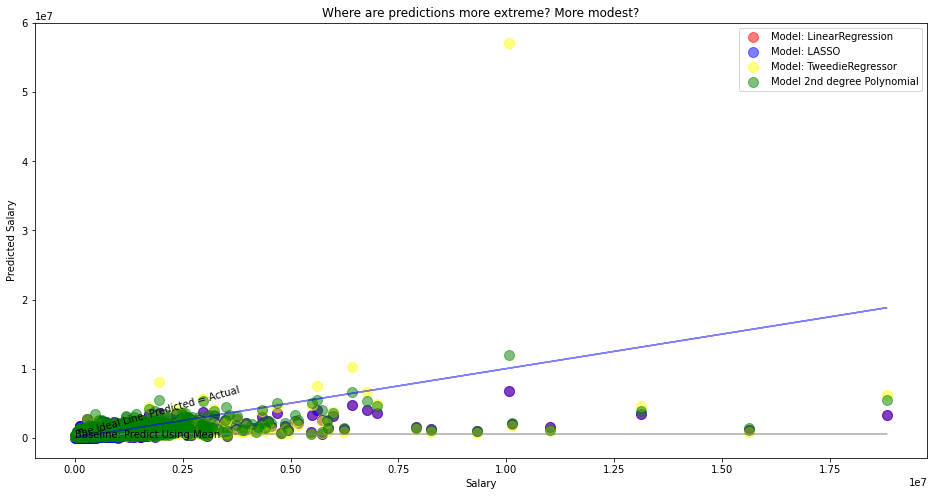

In [97]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.actual, y_validate.yhat_baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.actual, y_validate.actual, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.actual, y_validate.modelOLS, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.actual, y_validate.model_lasso, 
            alpha=.5, color="blue", s=100, label="Model: LASSO")
plt.scatter(y_validate.actual, y_validate.model_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.actual, y_validate.model_polreg, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Salary")
plt.ylabel("Predicted Salary")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

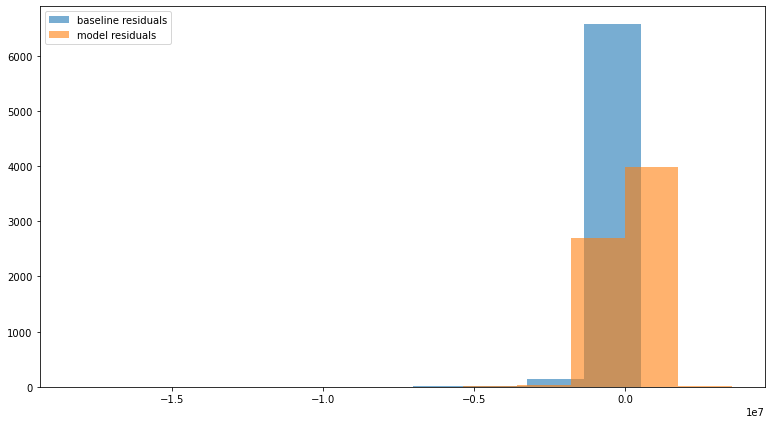

In [98]:
eval.plot_residuals(y_validate, 'actual', 'model_polreg')